In [1]:
import scanpy as sc

# Set display options
sc.settings.verbosity = 3
sc.logging.print_header()

# Load the data from your 'data' subfolder
adata = sc.read_10x_mtx(
    './data/',
    var_names='gene_symbols',
    cache=True)

# Print the AnnData object to see the summary
print(adata)

AnnData object with n_obs × n_vars = 13592 × 36601
    var: 'gene_ids', 'feature_types'


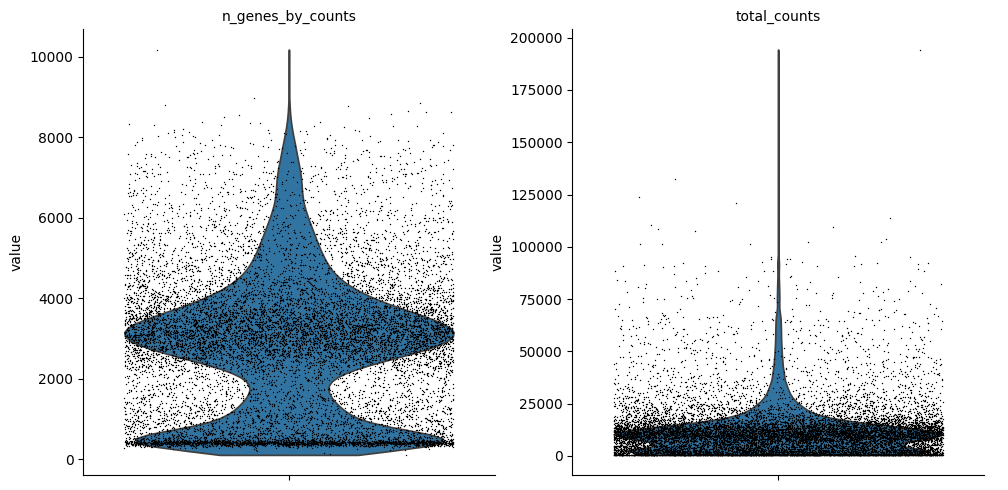

In [2]:
# Calculate quality control metrics
sc.pp.calculate_qc_metrics(adata, percent_top=None, inplace=True)

# Create a violin plot to visualize the QC metrics
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, multi_panel=True)

In [3]:
# Filter out cells that have fewer than 200 genes
sc.pp.filter_cells(adata, min_genes=200)

# Filter out cells that have more than 6000 genes (potential doublets)
adata = adata[adata.obs.n_genes_by_counts < 6000, :]

# Print the AnnData object again to see how many cells are left
print("After filtering:")
print(adata)

After filtering:
View of AnnData object with n_obs × n_vars = 12937 × 36601
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'


C:\Users\sayyi\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


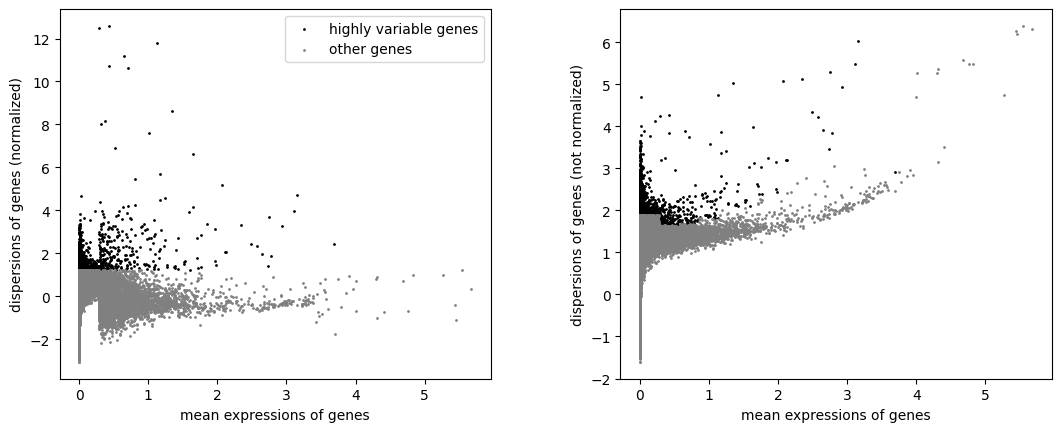

In [4]:
# Normalize every cell to a total of 10,000 reads and log-transform the data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Find and plot the top 2000 most-variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
sc.pl.highly_variable_genes(adata)

C:\Users\sayyi\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


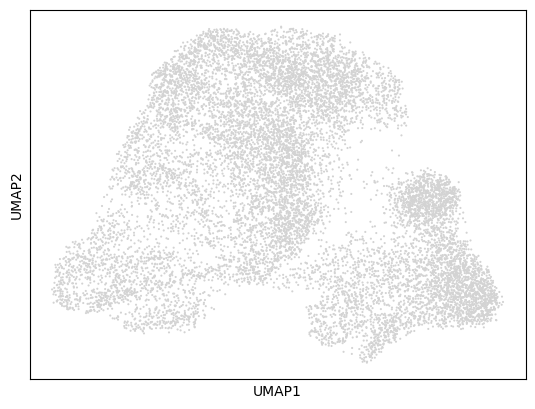

In [5]:
# First, we subset the data to only the highly variable genes
adata_hvg = adata[:, adata.var.highly_variable].copy()

# Run PCA - this is a preliminary step for UMAP
sc.tl.pca(adata_hvg, svd_solver='arpack')

# Calculate the neighborhood graph
sc.pp.neighbors(adata_hvg, n_neighbors=10, n_pcs=40)

# Create the UMAP plot
sc.tl.umap(adata_hvg)
sc.pl.umap(adata_hvg)

C:\Users\sayyi\AppData\Local\Temp\ipykernel_26224\3037325982.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_hvg)


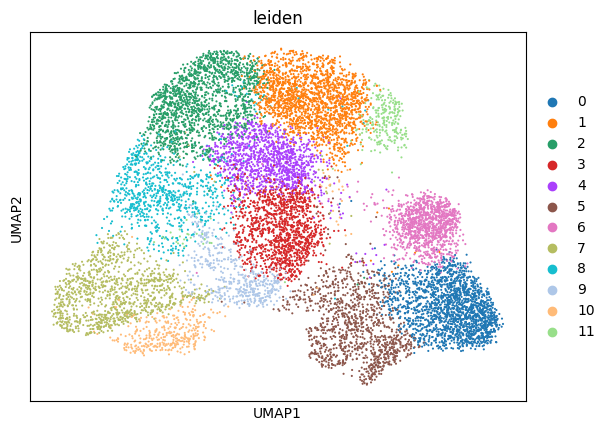

In [6]:
# Use the Leiden algorithm to find clusters of cells
sc.tl.leiden(adata_hvg)

# Create the UMAP plot again, but this time color by cluster
sc.pl.umap(adata_hvg, color=['leiden'])

In [7]:
import sys
!{sys.executable} -m pip install python-igraph


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
import sys
!{sys.executable} -m pip install leidenalg


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
# Create the input data (X) with our 2000 important genes
X = adata_hvg.X

# Create the output labels (y) which are the cluster IDs
y = adata_hvg.obs['leiden']

# Print the shapes to see our final data
print("Input data shape (cells, genes):", X.shape)
print("Output labels shape (cells,):", y.shape)

Input data shape (cells, genes): (12937, 2000)
Output labels shape (cells,): (12937,)


In [10]:
import pandas as pd
from scipy.sparse import save_npz

# Save the input data matrix (X) to a file
save_npz("./data/X_data.npz", X)

# Save the output labels (y) to a file
pd.Series(y).to_csv("./data/y_labels.csv", index=False)

print("Data saved successfully!")

Data saved successfully!


In [11]:
# Get the names of only the highly variable genes
hvg_names = adata.var_names[adata.var.highly_variable]

# Save this list to a new file
import pandas as pd
pd.DataFrame(hvg_names).to_csv("./data/hvg_names.csv", index=False, header=False)

print(f"Saved {len(hvg_names)} highly variable gene names to hvg_names.csv")

Saved 2000 highly variable gene names to hvg_names.csv
